In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
from read import Nw ,Ww ,Nb ,Wb ,Nk ,Wk ,Wsum
from drawing_utility import draw_scater_line_with_quatients, get_cur_x_of_draw_scater_line,\
    whites_draw_color,browns_draw_color,blacks_draw_color,sum_draw_color,indipendent_sum_draw_color
import statistics_utility
from statistics_of_single_ball import ball_mass_avr_b,ball_mass_avr_k,ball_mass_avr_w
from drawing_utility import show_with_heatmap, show_3D_scatter_projection
from itertools import product
import scipy.special

<Axes: >

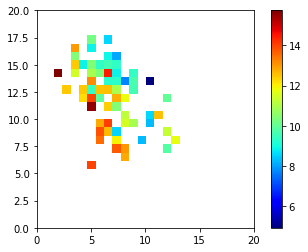

In [2]:
show_with_heatmap(Ww,Wb,Wk,1.3,20)

<Axes: xlabel='X Label', ylabel='Y Label'>

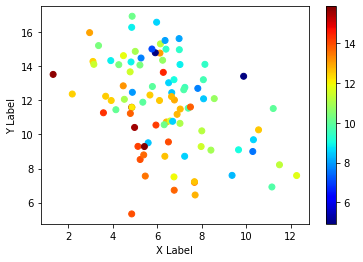

In [3]:
show_3D_scatter_projection(Ww,Wb,Wk)

<Axes: xlabel='X Label', ylabel='Y Label'>

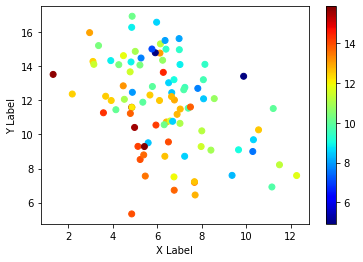

<Figure size 432x288 with 0 Axes>

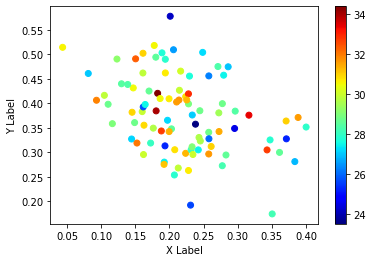

<Figure size 432x288 with 0 Axes>

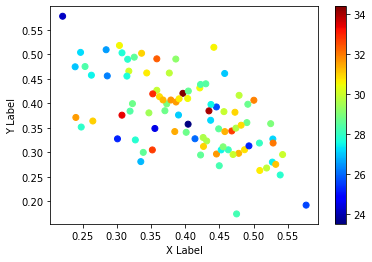

<Figure size 432x288 with 0 Axes>

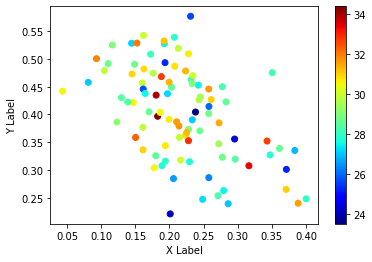

<Figure size 432x288 with 0 Axes>

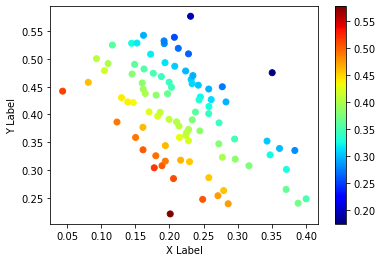

In [18]:
plt.figure()
show_3D_scatter_projection(Ww/Wsum,Wk/Wsum,Wsum)
plt.figure()
show_3D_scatter_projection(Wb/Wsum,Wk/Wsum,Wsum)
plt.figure()
show_3D_scatter_projection(Ww/Wsum,Wb/Wsum,Wsum)
plt.figure()
show_3D_scatter_projection(Ww/Wsum,Wb/Wsum,Wk/Wsum)

41.93103448275862
7.482985626848793


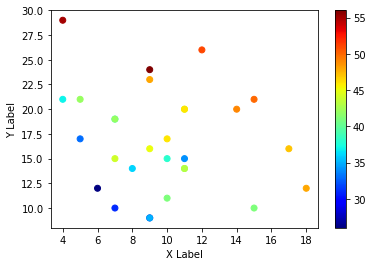

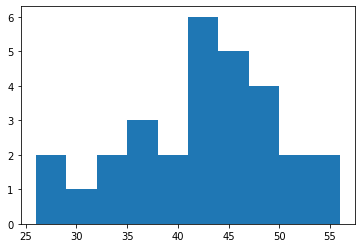

In [5]:
Nsum = Nw + Nb + Nk
show_3D_scatter_projection(Nw,Nb,Nsum)
plt.figure()
plt.hist(Nsum)
print(np.nanmean(Nsum))
print(np.nanstd(Nsum,ddof=1))

In [6]:
def get_normal(normal_w,normal_b):
    # assert 1-normal_w**2-normal_b**2 >= 0
    return (normal_w,normal_b,(1-normal_w**2-normal_b**2)**0.5)

def statistical_model(normal_w,normal_b,mean,std):
    prob_w = 0.21896850868981296
    prob_b = 0.40271531669606014
    prob_k = 0.37831617461412687
    pi = np.array([prob_w,prob_b,prob_k])
    
    normal = get_normal(normal_w,normal_b)
    def get_p_at_x(Ww,Wb,Wk):
        Ww_Wb_Wk = np.stack([Ww,Wb,Wk],axis=1)
        Ww_Wb_Wk = Ww_Wb_Wk[np.any(np.isfinite(Ww_Wb_Wk),axis=1)]
        d = np.dot(Ww_Wb_Wk,normal)
        d = (d - mean)/std
        p = np.exp(-0.5*d**2)/(np.sqrt(2*np.pi)*std)
        
        B = (scipy.special.gamma(1 + np.sum(Ww_Wb_Wk,axis=1)) /              \
             np.product(scipy.special.gamma(1 + Ww_Wb_Wk),axis=1)) *         \
             np.product(pi[np.newaxis,:] ** Ww_Wb_Wk,axis=1)
        
        p *= B
        return p
    return get_p_at_x      

def get_likelihood(normal_w,normal_b,mean,std):
    get_p_at_x = statistical_model(normal_w,normal_b,mean,std)
    return np.product(get_p_at_x(Ww,Wb,Wk))
    

In [12]:
one_over_three_root = 1/3**0.5
import tqdm


normal_w_arr = []
normal_b_arr = []
normal_k_arr = []
mean_arr = []
std_arr = []
likelihood_arr = []


iter = tqdm.tqdm(product(
     0.69115*np.linspace(0.99,1.01,11),
     0.49616*np.linspace(0.99,1.01,11),
     16.05390*np.linspace(0.99,1.01,11),
     1.20868**np.linspace(0.99,1.01,11)
     ))

for normal_w,normal_b,mean,std in iter:
     normal = get_normal(normal_w,normal_b)
     normal_w_arr.append(normal[0])
     normal_b_arr.append(normal[1])
     normal_k_arr.append(normal[2])
     mean_arr.append(mean)
     std_arr.append(std)
     likelihood_arr.append(get_likelihood(normal_w,normal_b,mean,std))

0it [00:00, ?it/s]

14641it [00:03, 4592.54it/s]


In [13]:
optimal_index = np.argmax(likelihood_arr)
print(
    f"{np.min(normal_w_arr):.5f}",
    f"{np.min(normal_b_arr):.5f}",
    f"{np.min(normal_k_arr):.5f}",
    f"{np.min(mean_arr):.5f}",
    f"{np.min(std_arr):.5f}",
    )
print(
    f"{normal_w_arr[optimal_index]:.5f}",
    f"{normal_b_arr[optimal_index]:.5f}",
    f"{normal_k_arr[optimal_index]:.5f}",
    f"{mean_arr[optimal_index]:.5f}",
    f"{std_arr[optimal_index]:.5f}",
    )
print(
    f"{np.max(normal_w_arr):.5f}",
    f"{np.max(normal_b_arr):.5f}",
    f"{np.max(normal_k_arr):.5f}",
    f"{np.max(mean_arr):.5f}",
    f"{np.max(std_arr):.5f}",
    )

0.68424 0.49120 0.51146 15.89336 1.20639
0.69115 0.49616 0.52549 16.05390 1.20868
0.69806 0.50112 0.53902 16.21444 1.21097


In [15]:
arr = np.stack([normal_w_arr,
normal_b_arr,
normal_k_arr,
mean_arr,
std_arr,
likelihood_arr,]).T
i_norm_w = 0
i_norm_b = 1
i_norm_k = 2
i_mean = 3
i_std = 4
i_lik = 5
optimal_vals = arr[optimal_index]

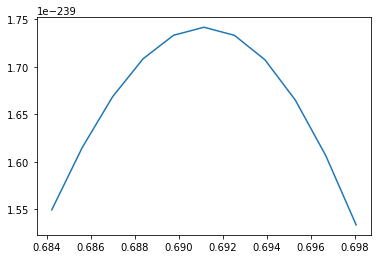

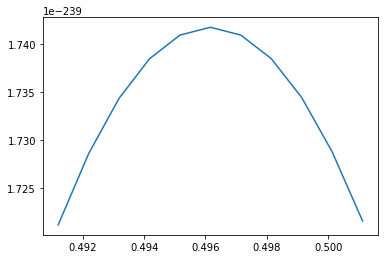

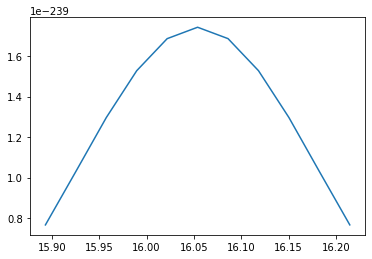

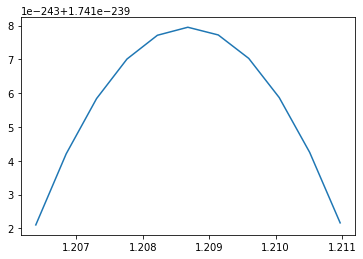

In [16]:
def plot_likelihood_single_var(var_index):
    indexes = np.full(arr.shape[0],True)
    for i in range(5):
        if i != var_index and i != 2:
            indexes *= (arr[:,i] == optimal_vals[i])
    arr_filtered = arr[indexes]
    plt.plot(arr_filtered[:,var_index],arr_filtered[:,i_lik])

plt.figure()
plot_likelihood_single_var(i_norm_w)
plt.figure()
plot_likelihood_single_var(i_norm_b)
plt.figure()
plot_likelihood_single_var(i_mean)
plt.figure()
plot_likelihood_single_var(i_std)


make 4 1d plots

C:\Users\Lior\AppData\Local\Temp\ipykernel_7560\3916892638.py:6: RuntimeWarning: invalid value encountered in scalar power
  return (normal_w,normal_b,(1-normal_w**2-normal_b**2)**0.5)


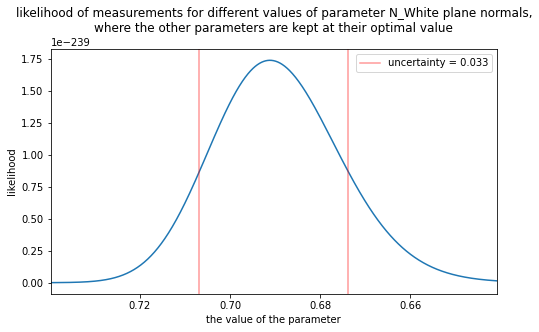

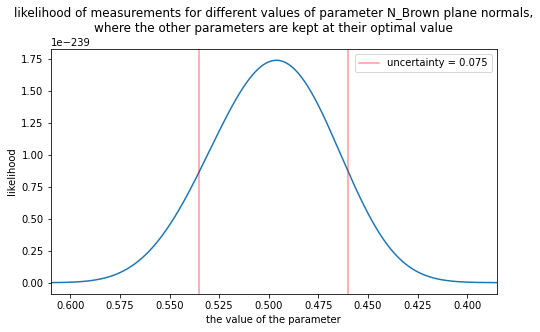

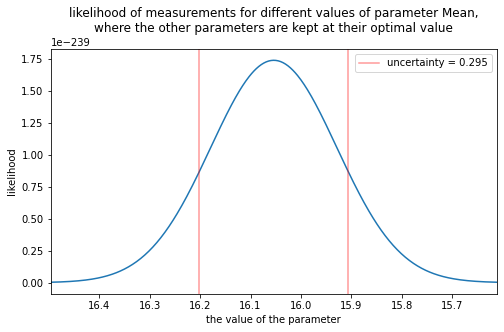

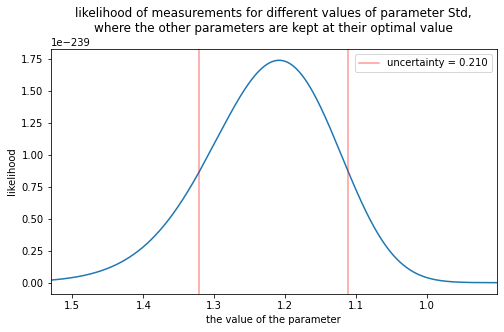

In [17]:

def plot_likelihood(par_index):
    arr_lik = []
    arr_par = []
    optimal_parameters = (0.69115,0.49616,16.05390,1.20868)
    for par in optimal_parameters[par_index]*np.linspace(0.5,1.5,10000):
        par_array = list(optimal_parameters)
        par_array[par_index] = par
        likelihood = get_likelihood(*par_array)        
        if not np.singlecomplex(likelihood):
            arr_par.append(par)
            arr_lik.append(likelihood)

    arr_lik = np.array(arr_lik)
    arr_par = np.array(arr_par)

    split_index = np.argmax(arr_lik)
    
    half_left = np.interp(np.max(arr_lik)/2,arr_lik[:split_index],arr_par[:split_index])
    half_right = np.interp(np.max(arr_lik)/2,arr_lik[:split_index:-1],arr_par[:split_index:-1])
    
    plt.plot(arr_par,arr_lik)
    plt.axvline(half_left,color="r",alpha=0.4,label=f"uncertainty = {half_right-half_left:.3f}")
    plt.axvline(half_right,color="r",alpha=0.4)
    plt.xlim((half_left + half_right)/2 - (half_left - half_right)*1.5, (half_left + half_right)/2 + (half_left - half_right)*1.5)
    plt.xlabel("the value of the parameter")
    plt.ylabel("likelihood")
    plt.legend()

param_text_arr = ["N_White plane normals","N_Brown plane normals","Mean","Std"]

for i in range(4):
    plt.figure(figsize=(8,4.5))
    plot_likelihood(i)
    plt.title("likelihood of measurements for different values of parameter #,\nwhere the other parameters are kept at their optimal value".replace("#",param_text_arr[i]))

In [40]:
# 0.69115 0.49616 0.52549
normal = (0.69115,0.49616,0.52549)
p1 = np.cross(normal,(1,-1,0))
p1 /= np.sum(p1**2)**0.5
p2 = np.cross(normal,p1)
p2 /= np.sum(p2**2)**0.5

Ww_Wb_Wk = np.stack([Ww,Wb,Wk],axis=1)
Ww_Wb_Wk = Ww_Wb_Wk[np.any(np.isfinite(Ww_Wb_Wk),axis=1)]

d0 = np.dot(Ww_Wb_Wk,normal)
d1 = np.dot(Ww_Wb_Wk,p1)
d2 = np.dot(Ww_Wb_Wk,p2)

print(np.mean(d0),np.std(d0))
print(np.mean(d1),np.std(d1))
print(np.mean(d2),np.std(d2))
# show_3D_scatter_projection(Ww,Wb,Wk)

16.05394325483871 1.208686212084618
-2.553355078262146 2.6984213545691103
6.0960208524696835 2.8228719040008605


(-8.644322329485153,
 5.200086332850477,
 -1.3981626965578784,
 12.238455033838873)

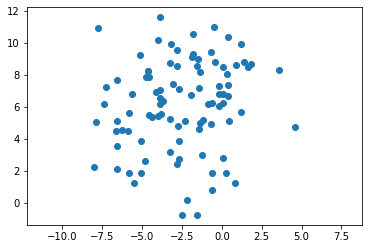

In [41]:
plt.plot(d1,d2,"o")
plt.axis("equal")

(-6.36185479019832, 8.023218615278418, -0.5128816770489472, 14.024670798369227)

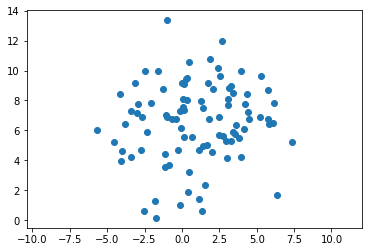

In [36]:
plt.plot(d1,d2,"o")
plt.axis("equal")

In [32]:
print(np.sum(p1**2),np.sum(p2**2))

1.0 0.9999999999999996
